<a href="https://colab.research.google.com/github/npr99/PlanningMethods/blob/master/PLAN604_Comparison_of_two_proportions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application of Comparing two Proportions from ACS Data
 
---
This Google Colab Notebook provides a complete workflow (sequence of steps from start to finish) that will allow you to explore two proportions found in ACS Data. 

This notebook compares population proportions found in the 2012 5-year ACS and the 2019 5-year ACS. The research question what census geographies have a stastically significant difference between two proportions found in two different ACS surveys. The 2012 5-year ACS includes random samples of households between 2008, 2009, 2010, 2011, and 2012. The 2019 5-year ACS includes random samples of households between 2015, 2016, 2017, 2018, and 2019.

### Two New python features in this notebook:

#### 1. Resuing code
This notebook introduces Python concepts of reading in and running a python file that includes reusable code. The code in the python file is stored on GitHub and has code that was introduced in earlier notebooks.

When a new pacakge is imported - such as `import pandas as pd` - the notebook is reading in python files that have been shared as open source. The python programming enviroment is simply many python files (`.py`) being referenced. Each (`.py`) is created and maintained by users across the globe.

#### 2. Loops
Loops are a powerful way to repeat functions across different values. In this notebook we will loop over multiple ACS years.



In [1]:
# Python packages required to read in and Census API data
import requests ## Required for the Census API
import pandas as pd # For reading, writing and wrangling data
import matplotlib.pyplot as plt # For plotting and making graphs

In [14]:
# Downloading and running python script from github
# https://jckantor.github.io/cbe61622/A.02-Downloading_Python_source_files_from_github.html
# Make sure the url is the raw version of the file on GitHub

user = "npr99"
repo = "PlanningMethods"
pyfile = "_planning_methods.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/master/{pyfile}"
!wget --no-cache --quiet --backups=1 {url}
print("Reading in python file from",url)
exec(open(pyfile).read())

Reading in python file from https://raw.githubusercontent.com/npr99/PlanningMethods/master/_planning_methods.py


## Step 1: Obtain Data
The previous step read in a python file with the Obtain Data function presented in the notebook on [Sample Size and Confidence Intervals](https://github.com/npr99/PlanningMethods/blob/master/PLAN604_Population_vs_Sample_USCounties.ipynb) The block of code with the python functions needs to be run first and then the function can be called in future blocks of code.

## Run Obtain Census API for 2012 and 2019 5-year ACS
The next block of code calls the function and gets varaibles related to public transportation use. The code is called in a loop.

For more variables see:

https://www.census.gov/data/developers/data-sets/acs-5year.2012.html

https://api.census.gov/data/2012/acs/acs5/subject/groups/S0801.html


In [15]:
help(obtain_census_api)

Help on function obtain_census_api in module __main__:

obtain_census_api(state: str = '*', county: str = '*', census_geography: str = 'county:*', vintage: str = '2010', dataset_name: str = 'dec/sf1', get_vars: str = 'GEO_ID')
    General utility for obtaining census from Census API.
    
    Args:
        state (str): 2-digit FIPS code. Default * for all states
        county (str): 3-digit FIPS code. Default * all counties
        census_geography (str): example '&for=block:*' would be for all blocks
          default is for all counties
        vintage (str): Census Year. Default 2010
        dataset_name (str): Census dataset name. Default Decennial SF1
        for a list of all Census API
        get_vars (str): list of variables to get from the API.
    
    Returns:
        obj, dict: A dataframe for with Census data



In [18]:
# Loop example
for year in ['2012','2013','2014','2015']:
  print(year)

2012
2013
2014
2015


In [71]:
# Create an empty "container" to store multiple ACS years for the data
acs_df = {} 

dataset_name = 'acs/acs5/subject'
vintages = ['2012','2019']
get_vars = 'GEO_ID,NAME,S0801_C01_001E,S0801_C01_001M,S0801_C01_009E,S0801_C01_009M'
for vintage in vintages:
  acs_df[vintage] = obtain_census_api(get_vars = get_vars, dataset_name = dataset_name, vintage = vintage)

Census API data from: https://api.census.gov/data/2012/acs/acs5/subject?get=GEO_ID,NAME,S0801_C01_001E,S0801_C01_001M,S0801_C01_009E,S0801_C01_009M&in=state:*&in=county:*&for=county:*
Census API data from: https://api.census.gov/data/2019/acs/acs5/subject?get=GEO_ID,NAME,S0801_C01_001E,S0801_C01_001M,S0801_C01_009E,S0801_C01_009M&in=state:*&in=county:*&for=county:*


In [22]:
acs_df['2012'].head()

,GEO_ID,NAME,S0801_C01_001E,S0801_C01_001M,S0801_C01_009E,S0801_C01_009M,state,county
0,0500000US29115,"Linn County, Missouri",5052,234,0.0,0.1,29,115
1,0500000US29091,"Howell County, Missouri",15623,560,0.3,0.3,29,091
2,0500000US29101,"Johnson County, Missouri",25227,677,0.3,0.2,29,101
3,0500000US29105,"Laclede County, Missouri",15019,481,0.1,0.2,29,105
4,0500000US29125,"Maries County, Missouri",3830,246,0.4,0.6,29,125


In [68]:
acs_df['2019'].head()

,GEO_ID,NAME,S0801_C01_001E,S0801_C01_001M,S0801_C01_009E,S0801_C01_009M,state,county
0,0500000US17051,"Fayette County, Illinois",8633,353,0.8,0.4,17,051
1,0500000US17107,"Logan County, Illinois",12211,378,0.4,0.3,17,107
2,0500000US17165,"Saline County, Illinois",9631,334,0.9,0.6,17,165
3,0500000US17097,"Lake County, Illinois",355918,2280,4.4,0.2,17,097
4,0500000US17127,"Massac County, Illinois",5602,268,0.3,0.5,17,127


## Step 2: Clean Data
Data cleaning is an important step in the data science process. This step is often the hardest and most time consuming. 

### 2.1. Clean ACS Data
#### 2.1.1 Make sure variable types are set correctly
For the ACS data we have both population counts and precents. The percentage estiamtes are not integers - they are "floats" which refers the the decimal place that can float in the number between the integer and the fractional part. Here is more information on Python number types https://www.tutorialspoint.com/python/python_numbers.htm 

In [73]:
for vintage in vintages:
  for variable in get_vars.split(","):
    variable_metadata_hyperlink = (f'https://api.census.gov/data/{vintage}/{dataset_name}/variables/{variable}.json')
    # Obtain Census API JSON Data
    !wget --no-cache --quiet --backups=1 {variable_metadata_hyperlink}

    with open(f"{variable}.json", "r") as rf:
      variable_metadata = json.load(rf)

    # Find the variable label 
    census_label_string = str(variable_metadata["label"])
    last_exclamation_point_position = census_label_string.rfind("!!")
    if last_exclamation_point_position >= 0:
      last_exclamation_point_position = last_exclamation_point_position + 2
    else:
      last_exclamation_point_position = 0
    label = census_label_string[last_exclamation_point_position:] 

    # Add vintage to label name (skip geo_id and name variables)
    if variable not in ['GEO_ID','NAME']:
      label_addvintage = label + f' {vintage}'
    else:
      label_addvintage = label

    # Add estimate or Margin of Error to label
    last_letter_of_variable = variable[-1]
    if variable not in ['GEO_ID','NAME']:
      if last_letter_of_variable == 'E':
        label_addvintage_addtype = label_addvintage + ' (Estimate)'
      if last_letter_of_variable == 'M':
        label_addvintage_addtype = label_addvintage + ' (MOE)'
    else:
      label_addvintage_addtype = label_addvintage
    print(vintage,"Renameing",variable," = ",label_addvintage_addtype,"Changing type to",variable_metadata["predicateType"])

    # Change variable type
    acs_df[vintage][variable] = acs_df[vintage][variable].astype(variable_metadata["predicateType"])

    acs_df[vintage] = acs_df[vintage].rename(columns={variable: label_addvintage_addtype}) 




2012 GEO_ID Geography string
2012 NAME Geographic Area Name string
2012 S0801_C01_001E Workers 16 years and over 2012 (Estimate) int
2012 S0801_C01_001M Workers 16 years and over 2012 (MOE) int
2012 S0801_C01_009E Public transportation (excluding taxicab) 2012 (Estimate) float
2012 S0801_C01_009M Public transportation (excluding taxicab) 2012 (MOE) float
2019 GEO_ID Geography string
2019 NAME Geographic Area Name string
2019 S0801_C01_001E Workers 16 years and over 2019 (Estimate) int
2019 S0801_C01_001M Workers 16 years and over 2019 (MOE) int
2019 S0801_C01_009E Public transportation (excluding taxicab) 2019 (Estimate) float
2019 S0801_C01_009M Public transportation (excluding taxicab) 2019 (MOE) float


In [74]:
acs_df['2012'].head()

,Geography,Geographic Area Name,Workers 16 years and over 2012 (Estimate),Workers 16 years and over 2012 (MOE),Public transportation (excluding taxicab) 2012 (Estimate),Public transportation (excluding taxicab) 2012 (MOE),state,county
0,0500000US29115,"Linn County, Missouri",5052,234,0.0,0.1,29,115
1,0500000US29091,"Howell County, Missouri",15623,560,0.3,0.3,29,091
2,0500000US29101,"Johnson County, Missouri",25227,677,0.3,0.2,29,101
3,0500000US29105,"Laclede County, Missouri",15019,481,0.1,0.2,29,105
4,0500000US29125,"Maries County, Missouri",3830,246,0.4,0.6,29,125


#### 2.1.2 Use descriptive statistics to check cleaning
A descriptive statistics table is a great way to check to make sure the variables have been created correctly.

In [78]:
float_col_list = list(acs_df['2012'].select_dtypes(include=['float']).columns)
table1 = acs_df['2012'][float_col_list].describe().T
varformat = "{:,.2f}" # The variable format adds a comma and rounds up
table_title = "Table 1. Descriptive statistics for variables by county, 2012 5-year ACS."
table1 = table1.style.set_caption(table_title).format(varformat).set_properties(**{'text-align': 'right'})
table1

,count,mean,std,min,25%,50%,75%,max
Public transportation (excluding taxicab) 2012 (Estimate),"3,221.00",0.97,3.00,0.00,0.10,0.40,0.80,60.80
Public transportation (excluding taxicab) 2012 (MOE),"3,221.00",0.66,1.46,0.10,0.20,0.30,0.70,40.00


In [79]:
float_col_list = list(acs_df['2019'].select_dtypes(include=['float']).columns)
table2 = acs_df['2019'][float_col_list].describe().T
varformat = "{:,.2f}" # The variable format adds a comma and rounds up
table_title = "Table 2. Descriptive statistics for variables by county, 2019 5-year ACS."
table2 = table2.style.set_caption(table_title).format(varformat).set_properties(**{'text-align': 'right'})
table2

,count,mean,std,min,25%,50%,75%,max
Public transportation (excluding taxicab) 2019 (Estimate),"3,220.00",0.91,3.05,0.00,0.10,0.30,0.70,61.20
Public transportation (excluding taxicab) 2019 (MOE),"3,220.00",0.67,1.55,0.10,0.20,0.30,0.60,59.00


## Step 3: Merge Data together
Merging data together is a powerful tool in data science workflows. Merge data refers to combining data that represent the same unit of analysis. In this example all three datasets represent counties in the US. Each dataframe has a common variable called GEO_ID which uniquely identifies the counties.

Here is a good overview of data merging in python:
https://towardsdatascience.com/why-and-how-to-use-merge-with-pandas-in-python-548600f7e738

### 3.1 - Merge Part 1 - Combine ACS Data

In [80]:
acs_df['2012'].head()

,Geography,Geographic Area Name,Workers 16 years and over 2012 (Estimate),Workers 16 years and over 2012 (MOE),Public transportation (excluding taxicab) 2012 (Estimate),Public transportation (excluding taxicab) 2012 (MOE),state,county
0,0500000US29115,"Linn County, Missouri",5052,234,0.0,0.1,29,115
1,0500000US29091,"Howell County, Missouri",15623,560,0.3,0.3,29,091
2,0500000US29101,"Johnson County, Missouri",25227,677,0.3,0.2,29,101
3,0500000US29105,"Laclede County, Missouri",15019,481,0.1,0.2,29,105
4,0500000US29125,"Maries County, Missouri",3830,246,0.4,0.6,29,125


In [81]:
acs_df['2019'].head()

,Geography,Geographic Area Name,Workers 16 years and over 2019 (Estimate),Workers 16 years and over 2019 (MOE),Public transportation (excluding taxicab) 2019 (Estimate),Public transportation (excluding taxicab) 2019 (MOE),state,county
0,0500000US17051,"Fayette County, Illinois",8633,353,0.8,0.4,17,051
1,0500000US17107,"Logan County, Illinois",12211,378,0.4,0.3,17,107
2,0500000US17165,"Saline County, Illinois",9631,334,0.9,0.6,17,165
3,0500000US17097,"Lake County, Illinois",355918,2280,4.4,0.2,17,097
4,0500000US17127,"Massac County, Illinois",5602,268,0.3,0.5,17,127


In [91]:
merge_df = pd.merge(left = acs_df['2012'],
                    right = acs_df['2019'],
                    left_on = ['Geography','Geographic Area Name'],
                    right_on = ['Geography','Geographic Area Name'],
                    how = 'inner')
merge_df.head()

,Geography,Geographic Area Name,Workers 16 years and over 2012 (Estimate),Workers 16 years and over 2012 (MOE),Public transportation (excluding taxicab) 2012 (Estimate),Public transportation (excluding taxicab) 2012 (MOE),state_x,county_x,Workers 16 years and over 2019 (Estimate),Workers 16 years and over 2019 (MOE),Public transportation (excluding taxicab) 2019 (Estimate),Public transportation (excluding taxicab) 2019 (MOE),state_y,county_y
0,0500000US29115,"Linn County, Missouri",5052,234,0.0,0.1,29,115,5579,158,0.0,0.5,29,115
1,0500000US29091,"Howell County, Missouri",15623,560,0.3,0.3,29,091,16210,514,0.4,0.4,29,091
2,0500000US29101,"Johnson County, Missouri",25227,677,0.3,0.2,29,101,26742,682,0.2,0.1,29,101
3,0500000US29105,"Laclede County, Missouri",15019,481,0.1,0.2,29,105,15395,663,0.0,0.2,29,105
4,0500000US29125,"Maries County, Missouri",3830,246,0.4,0.6,29,125,3716,254,0.2,0.3,29,125


In [96]:
float_col_list = list(merge_df.select_dtypes(include=['float']).columns)
table3 = merge_df[float_col_list].describe().T
varformat = "{:,.2f}" # The variable format adds a comma and rounds up
table_title = "Table 3. Descriptive statistics for variables by county, 2012 & 2019 5-year ACS."
table3 = table3.style.set_caption(table_title).format(varformat).set_properties(**{'text-align': 'right'})
table3

,count,mean,std,min,25%,50%,75%,max
Public transportation (excluding taxicab) 2012 (Estimate),"3,217.00",0.97,3.00,0.00,0.10,0.40,0.80,60.80
Public transportation (excluding taxicab) 2012 (MOE),"3,217.00",0.66,1.46,0.10,0.20,0.30,0.70,40.00
Public transportation (excluding taxicab) 2019 (Estimate),"3,217.00",0.91,3.05,0.00,0.10,0.30,0.70,61.20
Public transportation (excluding taxicab) 2019 (MOE),"3,217.00",0.67,1.55,0.10,0.20,0.30,0.60,59.00


### 3.3 Clean Up Merge File
Notice that the merge file has several columns (variables) that have repeated information. All three datafiles had a column called `name`. The name column is a good way to see that the merge has worked correctly. In this step we will also rename the columns.

### 3.3.1 Remove repeated columns

In [93]:
## The state and county columns also match - we can drop the repeated columns
merge_df = merge_df.drop(['state_y','county_y'], axis = 1)
merge_df.head()

,Geography,Geographic Area Name,Workers 16 years and over 2012 (Estimate),Workers 16 years and over 2012 (MOE),Public transportation (excluding taxicab) 2012 (Estimate),Public transportation (excluding taxicab) 2012 (MOE),county_x,Workers 16 years and over 2019 (Estimate),Workers 16 years and over 2019 (MOE),Public transportation (excluding taxicab) 2019 (Estimate),Public transportation (excluding taxicab) 2019 (MOE)
0,0500000US29115,"Linn County, Missouri",5052,234,0.0,0.1,115,5579,158,0.0,0.5
1,0500000US29091,"Howell County, Missouri",15623,560,0.3,0.3,091,16210,514,0.4,0.4
2,0500000US29101,"Johnson County, Missouri",25227,677,0.3,0.2,101,26742,682,0.2,0.1
3,0500000US29105,"Laclede County, Missouri",15019,481,0.1,0.2,105,15395,663,0.0,0.2
4,0500000US29125,"Maries County, Missouri",3830,246,0.4,0.6,125,3716,254,0.2,0.3


### 3.3.2 Add new variable
Add difference between ACS statiscs

In [123]:
percent1 = 'Public transportation (excluding taxicab) 2019 (Estimate)'
percent2 = 'Public transportation (excluding taxicab) 2012 (Estimate)'
merge_df.loc[:,'Difference between Percent'] = (merge_df[percent1]) - (merge_df[percent2])
merge_df['Difference between Percents'].describe()

count    3217.000000
mean       -0.067454
std         0.810308
min       -17.000000
25%        -0.300000
50%         0.000000
75%         0.200000
max        18.400000
Name: Difference between Percents, dtype: float64

Add standard error for the pooled estimate

In [124]:
moe1 = 'Public transportation (excluding taxicab) 2019 (MOE)'
moe2 = 'Public transportation (excluding taxicab) 2012 (MOE)'
census_critical_value = 1.645
merge_df.loc[:,'Standard Error 1'] = (merge_df[moe1])/census_critical_value
merge_df.loc[:,'Standard Error 2'] = (merge_df[moe2])/census_critical_value
merge_df.loc[:,'Difference Standard Error'] = (merge_df['Standard Error 1']**2 + merge_df['Standard Error 2']**2)**(-1/2)
merge_df['Difference Standard Error'].describe()

count    3217.000000
mean        3.725210
std         2.794229
min         0.023168
25%         1.661701
50%         3.054688
75%         5.201947
max        11.631907
Name: Difference Standard Error, dtype: float64

Add test statistic for difference

In [125]:
merge_df.loc[:,'Test Statistic'] = abs(merge_df['Difference between Percents'] / merge_df['Difference Standard Error'])
merge_df['Test Statistic'].describe()

count    3217.000000
mean        0.419156
std         2.664195
min         0.000000
25%         0.017194
50%         0.060790
75%         0.203897
max        74.078825
Name: Test Statistic, dtype: float64

## Step 4: Explore Data
### 4.1 - Which Counties had significant changes?

In [126]:
merge_df.loc[(merge_df['Test Statistic'] >= 1.645) & 
             (merge_df['Difference between Percents'] > 0) &
             ()]

,Geography,Geographic Area Name,Workers 16 years and over 2012 (Estimate),Workers 16 years and over 2012 (MOE),Public transportation (excluding taxicab) 2012 (Estimate),Public transportation (excluding taxicab) 2012 (MOE),county_x,Workers 16 years and over 2019 (Estimate),Workers 16 years and over 2019 (MOE),Public transportation (excluding taxicab) 2019 (Estimate),Public transportation (excluding taxicab) 2019 (MOE),Difference between Proportions,Difference between Percents,Difference Standard Error,Standard Error 1,Standard Error 2,Test Statistic,Difference between Percent
39,0500000US30097,"Sweet Grass County, Montana",1712,122,2.9,1.4,097,1560,131,5.9,2.6,0.030,3.0,0.557067,1.580547,0.851064,5.385346,3.0
50,0500000US30057,"Madison County, Montana",3923,184,0.1,0.1,057,3932,232,1.7,2.1,0.016,1.6,0.782447,1.276596,0.060790,2.044868,1.6
263,0500000US06051,"Mono County, California",7812,455,2.9,1.5,051,8302,611,21.3,5.4,0.184,18.4,0.293516,3.282675,0.911854,62.688213,18.4
285,0500000US08051,"Gunnison County, Colorado",8682,341,3.0,1.2,051,9470,400,5.4,1.9,0.024,2.4,0.732015,1.155015,0.729483,3.278620,2.4
297,0500000US08011,"Bent County, Colorado",1618,269,0.2,0.5,011,1439,189,2.7,3.4,0.025,2.5,0.478675,2.066869,0.303951,5.222748,2.5
377,0500000US08097,"Pitkin County, Colorado",9851,507,10.7,2.6,097,11730,370,19.0,5.0,0.083,8.3,0.291894,3.039514,1.580547,28.434948,8.3
603,0500000US48153,"Floyd County, Texas",2841,179,0.0,1.3,153,2415,158,1.4,1.6,0.014,1.4,0.797942,0.972644,0.790274,1.754513,1.4
749,0500000US17069,"Hardin County, Illinois",1504,142,0.7,0.6,069,1290,171,2.9,2.8,0.022,2.2,0.574459,1.702128,0.364742,3.829691,2.2
787,0500000US32011,"Eureka County, Nevada",771,111,4.0,2.6,011,930,162,9.8,5.6,0.058,5.8,0.266434,3.404255,1.580547,21.769003,5.8
788,0500000US32013,"Humboldt County, Nevada",7352,370,8.8,2.8,013,8377,290,11.9,2.4,0.031,3.1,0.446063,1.458967,1.702128,6.949687,3.1


In [ ]:
table5 = merge_pt2_df[['Total Population April 1 2010','Total Population ACS 2010 (estimate)']].loc[(merge_pt2_df['Total Population ACS 2010 (estimate)'].isnull())].describe().T
varformat = "{:,.0f}" # The variable format adds a comma and rounds up
table_title = "Table 5. Descriptive statistics for total population for counties without ACS data, 2010 Decennial."
table5 = table5.style.set_caption(table_title).format(varformat).set_properties(**{'text-align': 'right'})
table5

,count,mean,std,min,25%,50%,75%,max
Total Population April 1 2010,"2,403","21,730","16,010",82,"8,785","17,457","32,466","64,757"
Total Population ACS 2010 (estimate),0,nan,nan,nan,nan,nan,nan,nan


In [ ]:
table6 = merge_pt2_df[['Total Population April 1 2010','Total Population ACS 2010 (estimate)']].loc[~(merge_pt2_df['Total Population ACS 2010 (estimate)'].isnull())].describe().T
varformat = "{:,.0f}" # The variable format adds a comma and rounds up
table_title = "Table 6. Descriptive statistics for total population for counties with ACS data, 2010 Decennial."
table6 = table6.style.set_caption(table_title).format(varformat).set_properties(**{'text-align': 'right'})
table6

,count,mean,std,min,25%,50%,75%,max
Total Population April 1 2010,818,"318,159","557,363","64,665","95,286","153,956","312,155","9,818,605"
Total Population ACS 2010 (estimate),818,"318,861","558,543","62,971","95,588","154,018","314,120","9,830,420"


### ACS 1-year data available for census geographies with population more than 65,000

In [ ]:
merge_pt2_df = merge_pt2_df.sort_values(by = 'Total Population April 1 2010')
table7 = merge_pt2_df[['County Name','Total Population April 1 2010','Total Population ACS 2010 (estimate)']].loc[(merge_pt2_df['Total Population April 1 2010'] >= 64000) &
                 (merge_pt2_df['Total Population April 1 2010'] <= 66000) ]
varformat = {"Total Population April 1 2010": "{:,.0f}", 
             "Total Population ACS 2010 (estimate)": "{:,.0f}"}
table_title = "Table 7. Total population for counties around 65,000 peoople for Decennial and ACS data, 2010."
table7 = table7.style.set_caption(table_title).set_properties(**{'text-align': 'right'}).format(varformat)
table7

,County Name,Total Population April 1 2010,Total Population ACS 2010 (estimate)
1839,"Blue Earth County, Minnesota","64,013",nan
2541,"Spalding County, Georgia","64,073",nan
2307,"Rice County, Minnesota","64,142",nan
1226,"Reno County, Kansas","64,511",nan
489,"Herkimer County, New York","64,519",nan
1165,"Nacogdoches County, Texas","64,524",nan
26,"Lake County, California","64,665","64,771"
641,"Lea County, New Mexico","64,727",nan
1279,"Athens County, Ohio","64,757",nan
1196,"San Patricio County, Texas","64,804","64,586"


## 4.2 Compare ACS Estimate with Decennial Census Parameter

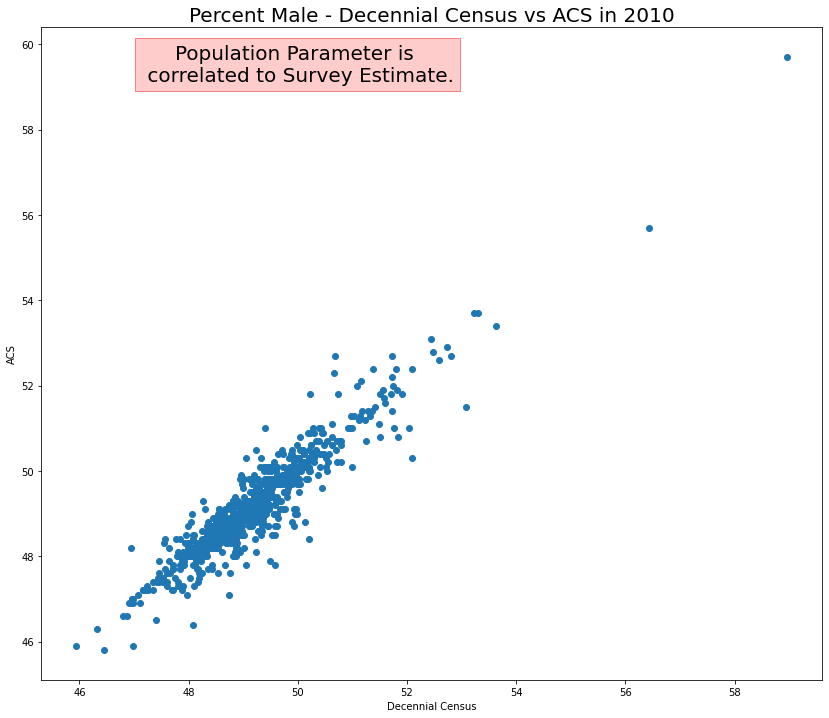

In [ ]:
# Scatter Plot
plt.figure(figsize=(14, 12))
plt.scatter(merge_pt2_df["Percent Male April 1 2010"], merge_pt2_df["Percent Male Population ACS 2010 (estimate)"])
plt.title('Percent Male - Decennial Census vs ACS in 2010',  fontsize=20)
plt.xlabel("Decennial Census")
plt.ylabel('ACS')
plt.text(50, 60, "Population Parameter is \n correlated to Survey Estimate.", size=20,
         ha="center", va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
plt.show()

### How often was the population parameter inside the estimate confidence interval?

In [ ]:
merge_pt2_df.loc[:,'Estimate Lower Bound'] = merge_pt2_df["Percent Male Population ACS 2010 (estimate)"] - merge_pt2_df["Percent Male Population ACS 2010 (MOE)"]
merge_pt2_df.loc[:,'Estimate Upper Bound'] = merge_pt2_df["Percent Male Population ACS 2010 (estimate)"] + merge_pt2_df["Percent Male Population ACS 2010 (MOE)"]
merge_pt2_df.head()

,GEO_ID,County Name,Total Population April 1 2010,Total Male Population April 1 2010,State FIPS Code,County FIPS Code,Percent Male April 1 2010,Total Population ACS 2010 (estimate),Total Population ACS 2010 (MOE),Total Male Population ACS 2010 (estimate),Total Male Population ACS 2010 (MOE),Percent Male Population ACS 2010 (estimate),Percent Male Population ACS 2010 (MOE),Sample Size ACS 2010,Percent Sample Size,Estimate Lower Bound,Estimate Upper Bound
1346,0500000US48301,"Loving County, Texas",82,46,48,301,56.097561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2603,0500000US15005,"Kalawao County, Hawaii",90,42,15,005,46.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1329,0500000US48269,"King County, Texas",286,141,48,269,49.300699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1325,0500000US48261,"Kenedy County, Texas",416,212,48,261,50.961538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2421,0500000US31005,"Arthur County, Nebraska",460,228,31,005,49.565217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
merge_pt2_df.loc[(merge_pt2_df["Percent Male April 1 2010"] >= merge_pt2_df['Estimate Lower Bound']) &
                 (merge_pt2_df["Percent Male April 1 2010"] <= merge_pt2_df['Estimate Upper Bound']),'Parameter within Confidence Interval'] = 1
merge_pt2_df.loc[(merge_pt2_df["Percent Male April 1 2010"] < merge_pt2_df['Estimate Lower Bound']) ,'Parameter within Confidence Interval'] = 0
merge_pt2_df.loc[(merge_pt2_df["Percent Male April 1 2010"] > merge_pt2_df['Estimate Upper Bound']) ,'Parameter within Confidence Interval'] = 0
merge_pt2_df.loc[(merge_pt2_df['Estimate Lower Bound'].isnull()) ,'Parameter within Confidence Interval'] = np.nan
merge_pt2_df['Parameter within Confidence Interval'].describe()

count    807.000000
mean       0.824040
std        0.381023
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Parameter within Confidence Interval, dtype: float64

## 82% of the Population Parameters are within the 90% Confidence Intervals for the Survey Estimates

In [ ]:
merge_pt2_df.loc[:,'Parameter minus Estimate'] = merge_pt2_df["Percent Male April 1 2010"] - merge_pt2_df["Percent Male Population ACS 2010 (estimate)"]
merge_pt2_df['Parameter minus Estimate'].describe()

count    818.000000
mean       0.008826
std        0.419756
min       -2.017828
25%       -0.171638
50%       -0.007309
75%        0.184919
max        1.811088
Name: Parameter minus Estimate, dtype: float64

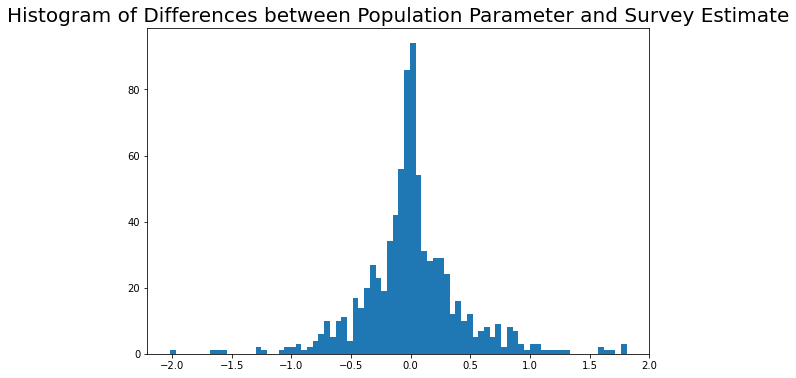

In [ ]:
plt.figure(figsize=(9, 6))
plt.hist(merge_pt2_df['Parameter minus Estimate'],bins = 80)
plt.title("Histogram of Differences between Population Parameter and Survey Estimate",  fontsize=20)
plt.show()

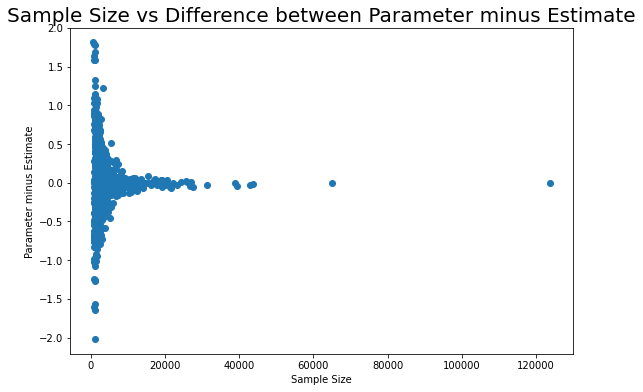

In [ ]:
# Scatter Plot
plt.figure(figsize=(9, 6))
plt.scatter(merge_pt2_df["Sample Size ACS 2010"], merge_pt2_df["Parameter minus Estimate"])
plt.title('Sample Size vs Difference between Parameter minus Estimate',  fontsize=20)
plt.xlabel("Sample Size")
plt.ylabel('Parameter minus Estimate')
plt.show()

### Look at Standard Errors
Instead of the difference between Population Paramter and Survey Estimate look at the number of Standard Errors the Population Parameter is from the survey estimate.

In [ ]:
merge_pt2_df.loc[:,"Percent Male Population ACS 2010 (SE)"] = merge_pt2_df["Percent Male Population ACS 2010 (MOE)"] / 1.645
merge_pt2_df["Percent Male Population ACS 2010 (SE)"].describe()

count    807.000000
mean       0.298452
std        0.216620
min        0.060790
25%        0.121581
50%        0.243161
75%        0.425532
max        1.458967
Name: Percent Male Population ACS 2010 (SE), dtype: float64

In [ ]:
merge_pt2_df.loc[:,'Parameter SE from Estimate'] = (merge_pt2_df['Parameter minus Estimate'] / merge_pt2_df["Percent Male Population ACS 2010 (SE)"])
merge_pt2_df['Parameter SE from Estimate'].describe()

count    807.000000
mean      -0.017162
std        1.208013
min       -3.333568
25%       -0.812244
50%       -0.066313
75%        0.773236
max        4.345792
Name: Parameter SE from Estimate, dtype: float64

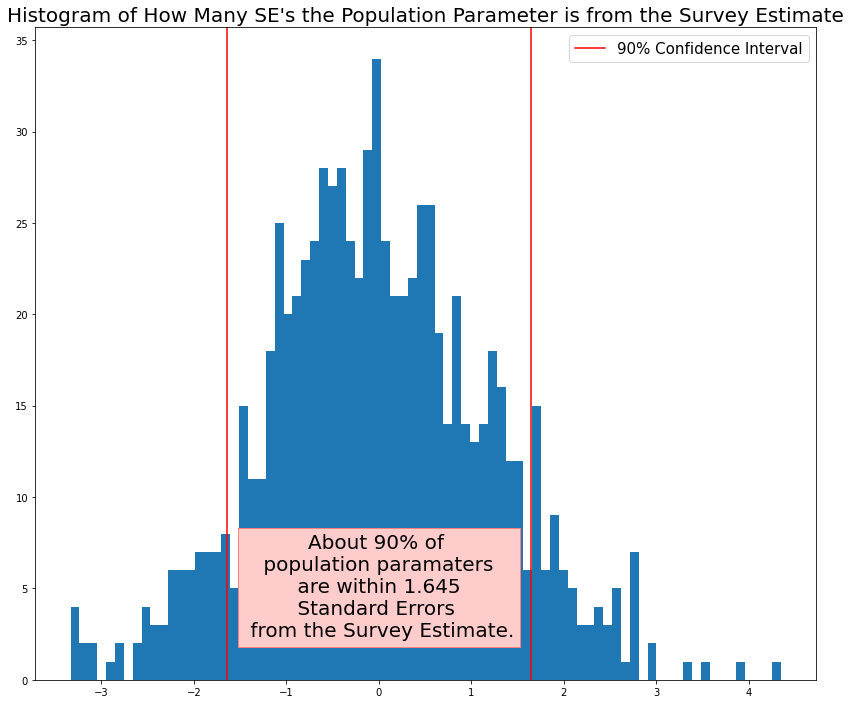

In [ ]:
plt.figure(figsize=(14, 12))
plt.hist(merge_pt2_df['Parameter SE from Estimate'],bins = 80)
plt.axvline(x=-1.645, color='red')
plt.axvline(x=1.645, label='90% Confidence Interval', color='red')
plt.legend(fontsize = 15)
plt.title("Histogram of How Many SE's the Population Parameter is from the Survey Estimate",  fontsize=20)
plt.text(0, 8, "About 90% of \n population paramaters \n are within 1.645 \n Standard Errors  \n from the Survey Estimate.", size=20,
         ha="center", va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
plt.show()

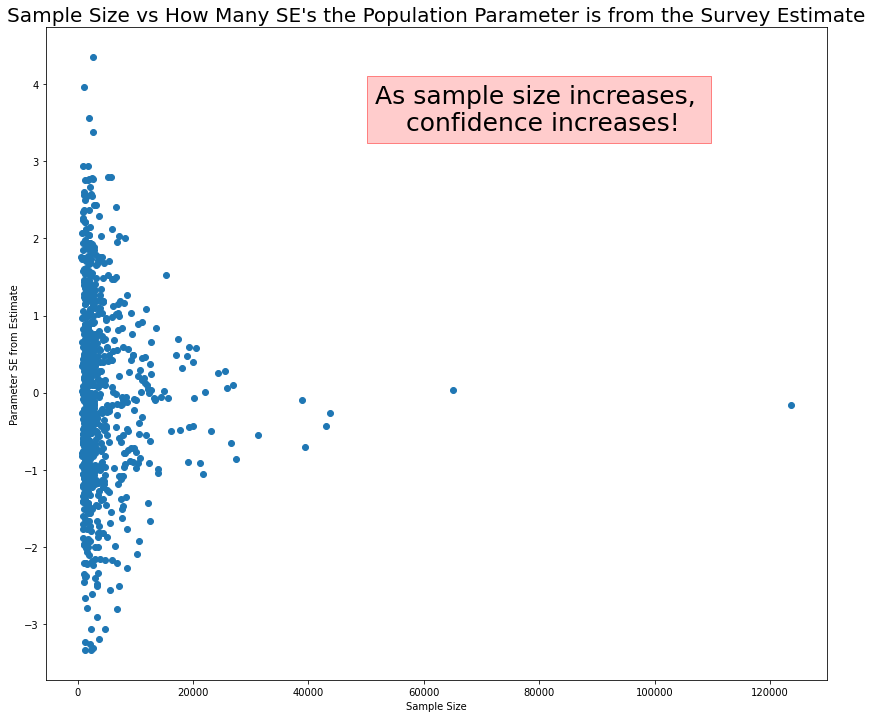

In [ ]:
# Scatter Plot
plt.figure(figsize=(14, 12))
plt.scatter(merge_pt2_df["Sample Size ACS 2010"], merge_pt2_df['Parameter SE from Estimate'])
plt.title("Sample Size vs How Many SE's the Population Parameter is from the Survey Estimate",  fontsize=20)
plt.xlabel("Sample Size")
plt.ylabel('Parameter SE from Estimate')
plt.text(80000, 4, "As sample size increases, \n confidence increases!", size=25,
         ha="center", va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
plt.show()

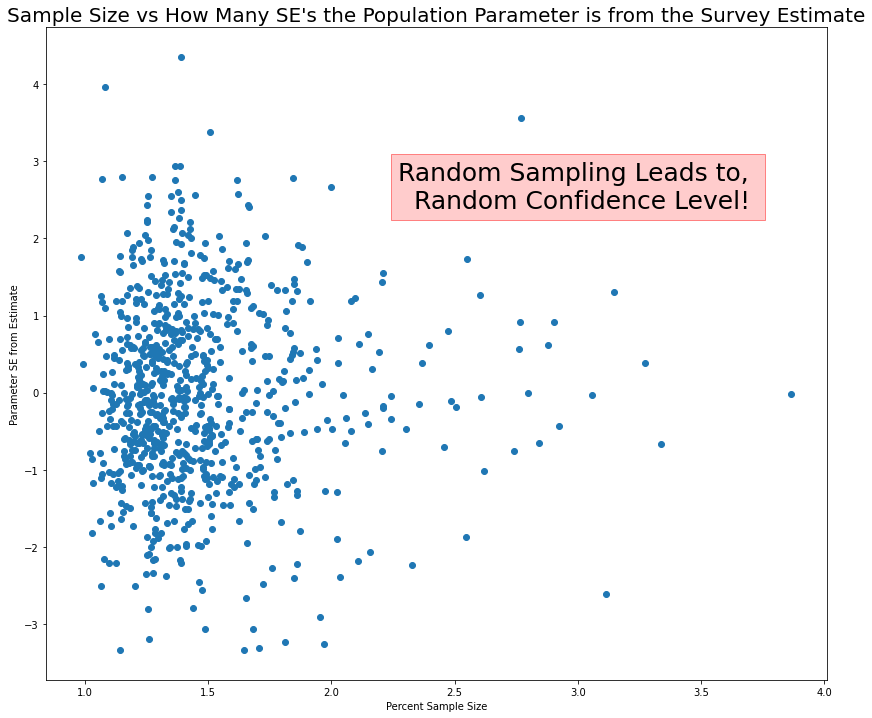

In [ ]:
# Scatter Plot
plt.figure(figsize=(14, 12))
plt.scatter(merge_pt2_df["Percent Sample Size"], merge_pt2_df['Parameter SE from Estimate'])
plt.title("Sample Size vs How Many SE's the Population Parameter is from the Survey Estimate",  fontsize=20)
plt.xlabel("Percent Sample Size")
plt.ylabel('Parameter SE from Estimate')
plt.text(3, 3, "Random Sampling Leads to, \n Random Confidence Level!", size=25,
         ha="center", va="top",
         bbox=dict(boxstyle="square",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8),
                   )
         )
plt.show()

## As sample size increases confidence level increases!

In [ ]:
merge_pt2_df['Parameter SE from Estimate'].quantile([0.005, 0.025, 0.05,0.95, 0.975, 0.995])

0.005   -3.223513
0.025   -2.365837
0.050   -1.989567
0.950    1.998981
0.975    2.434945
0.995    2.937258
Name: Parameter SE from Estimate, dtype: float64

### Compare the percentiles to critical values
Notice that the percentiles are somewhat to the z-score critical values for desired level of confidence.

- 1.645 for 90 perenct critical level
- 1.960 for 95 percent critical level
- 2.576 for 99 percent critical level

### What sample size do we need to get the desired confidence level?

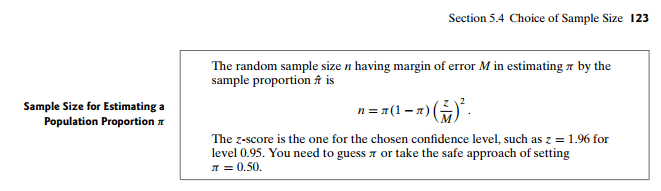

From Agresi (2017) we can use the above equation to calcuate the sample size need to estimate a population proportion.

In [ ]:
# What is the population proportion
merge_pt2_df['Percent Male April 1 2010'].describe()

count    3221.000000
mean       49.937432
std         2.211133
min        43.222315
25%        48.847653
50%        49.507874
75%        50.342431
max        72.110596
Name: Percent Male April 1 2010, dtype: float64

In [ ]:
# The proportion is the percentage divided by 100
population_proportion = 49.937432 / 100
population_proportion

0.49937432000000004

In [ ]:
# what is the critical value? 
# For 90% CI the z value is 1.645
z = 1.645

In [ ]:
M = .01

In [ ]:
n = population_proportion*(1 - population_proportion) * (z/M)**2
n

6765.051906576118

In [ ]:
merge_pt2_df["Sample Size ACS 2010"].describe()

count       818.000000
mean       4272.415648
std        6852.816290
min         637.000000
25%        1455.750000
50%        2295.000000
75%        4328.750000
max      123731.000000
Name: Sample Size ACS 2010, dtype: float64

In [ ]:
merge_pt2_df["Percent Male Population ACS 2010 (MOE)"].describe()

count    807.000000
mean       0.490954
std        0.356339
min        0.100000
25%        0.200000
50%        0.400000
75%        0.700000
max        2.400000
Name: Percent Male Population ACS 2010 (MOE), dtype: float64

### Agresti's Art of Stats
Coverage of Confidence Intervals provides a visual representation of the concept described above.
https://istats.shinyapps.io/ExploreCoverage/

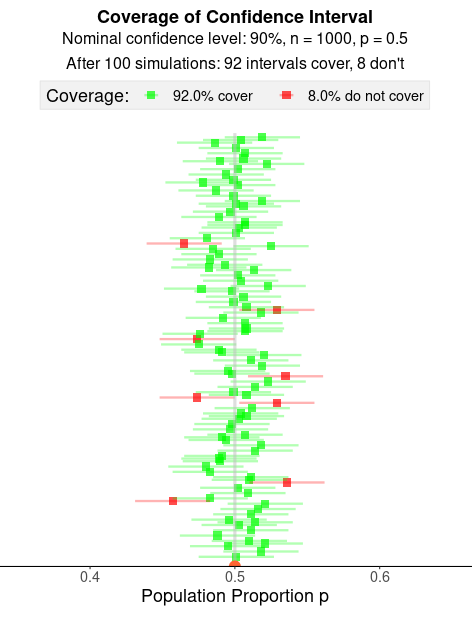